We solve the steady advection-diffusion equation $$-\kappa \Delta u + \mathbf{a}\cdot \nabla u = 0, \quad\text{where }\kappa =10^{-7} \text{ and } \mathbf{a} = \left(-y + 0.5\,,\,\, x - 0.5\right)^T $$

The domain is $0\le x, y\le 1$ and our solution satisfies the dirichlet boundary conditions indicated below. Especially important is the sine wave that extends from the center of the square to an edge.
<img src="files/ProblemSetup.png">
(pictures taken from this [paper](https://link.springer.com/content/pdf/10.1007/s11831-010-9042-5.pdf))

The exact solution (in the hyperbolic limit) is a solid of revolution of the sine wave about the z-axis through the center of the square.

In this notebook, the domain is defined as four patches, with the midline as the boundary of one of these patches. The splines are of the default smoothness (degree - 1) within a patch but are continuous across patches. This enables us to solve the problem with splines of degree larger than 1. The rest of the code goes exactly as seen in previous notebooks.

#### Methods used
1. Galerkin (strongly enforced BCs)
2. SUPG (strongly enforced BCs)



## Galerkin

**Weak Form**: $$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k} \,a_k \, dx$$
where $N_i$ is a basis function.

optimize > solve > solving 99 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 2e-17
optimize > constrained 99/529 dofs
optimize > optimum value 5.10e-09
solve > solving 430 dof system to machine precision using direct solver
solve > solver returned with residual 9e-18


<IPython.core.display.Javascript object>


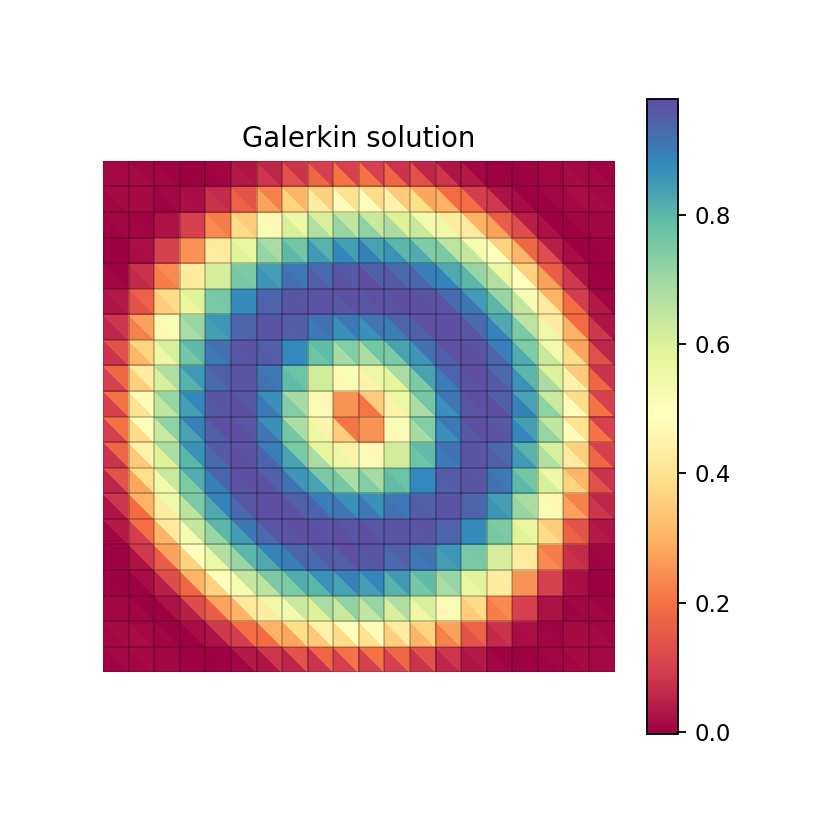

<IPython.core.display.Javascript object>


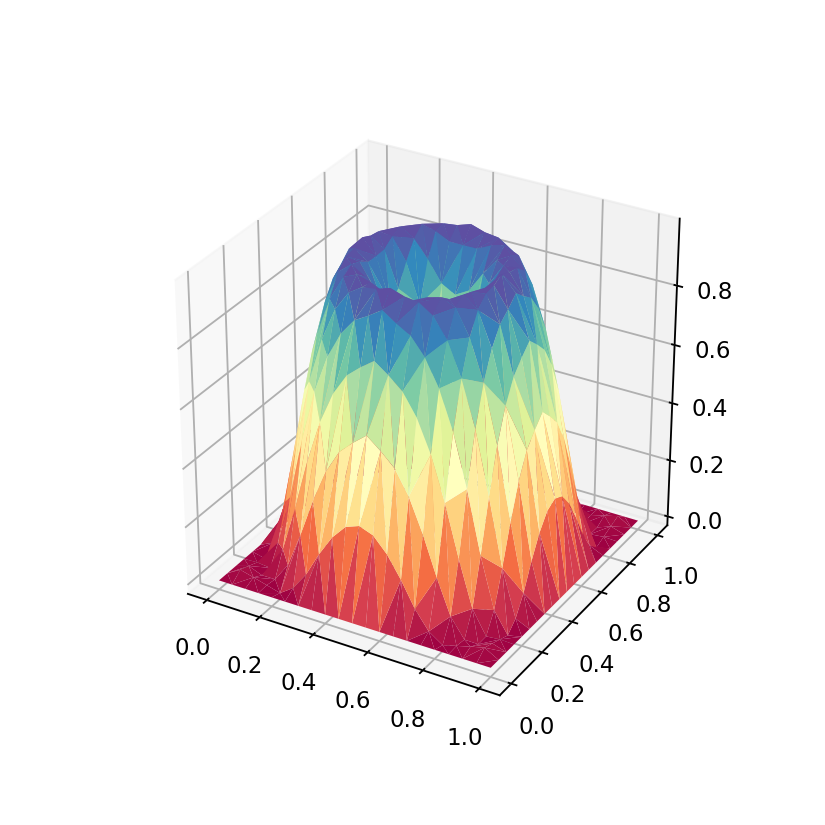

In [21]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

degree = 2 #degree of basis functions
nelems = 10 #number of elements along edge of unit square


#Connectivity :  6──7──8
#                │  │  │
#                3──4──5
#                │  │  │
#                0──1──2


topo, geom =ntl.mesh.multipatch(patches=[[0, 3, 1, 4], [3, 6, 4, 7], [4, 7, 5, 8], [1, 4, 2, 5]],
                                patchverts=[[0,0], [.5, 0], [1, 0], [0, .5], [.5, .5], [1, .5], 
                                            [0, 1], [.5, 1], [1, 1]],
                               nelems= nelems)

topo0 = topo['patch0'] #[0, 3, 1, 4]
topo1 = topo['patch1'] #[3, 6, 4, 7]
topo2 = topo['patch2'] #[4, 7, 5, 8]
topo3 = topo['patch3'] #[1, 4, 2, 5]

ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('spline', degree = degree)
ns.u = 'basis_i ?dofs_i'
 
#boundary conditions    
sqr = topo2.boundary['bottom'].integral('( u - sin(2 pi (x_0 - 0.5))  )^2 d:x' @ ns, degree= degree*2)

sqr += topo0.boundary['bottom'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo3.boundary['bottom'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo0.boundary['left'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo1.boundary['left'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo1.boundary['top'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo2.boundary['top'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo2.boundary['right'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo3.boundary['right'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo0.boundary['left'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

#this converts our solution into arrays
bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('RF_Gal.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap = plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

### SUPG

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, a_n N_{A, n} 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below

optimize > solve > solving 126 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 2e-17
optimize > constrained 126/841 dofs
optimize > optimum value 1.39e-16
solve > solving 715 dof system to machine precision using direct solver
solve > solver returned with residual 8e-17


<IPython.core.display.Javascript object>


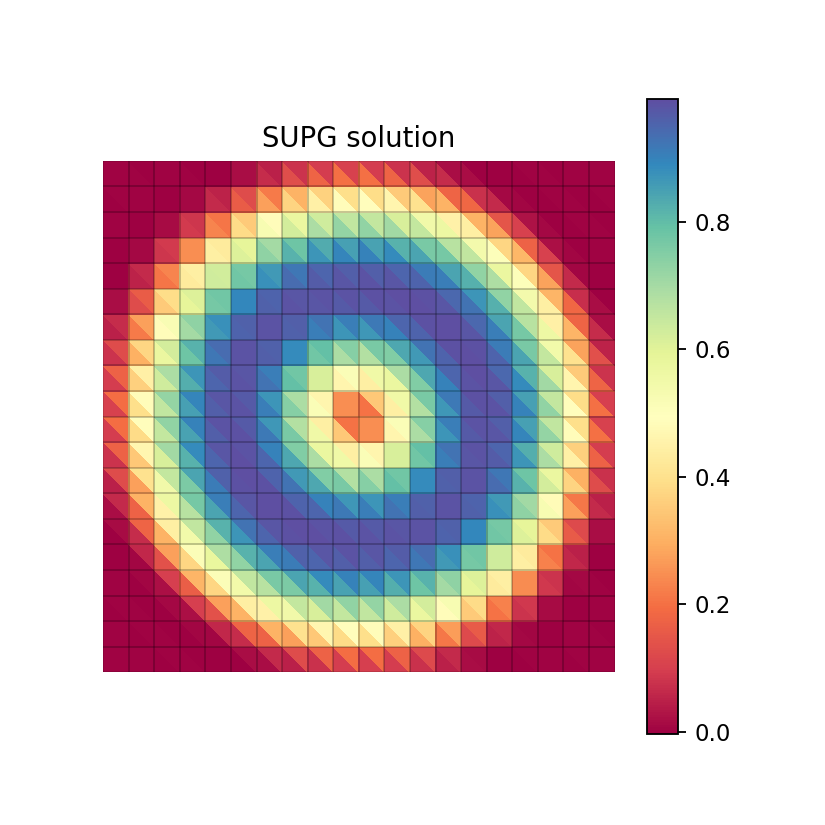

<IPython.core.display.Javascript object>


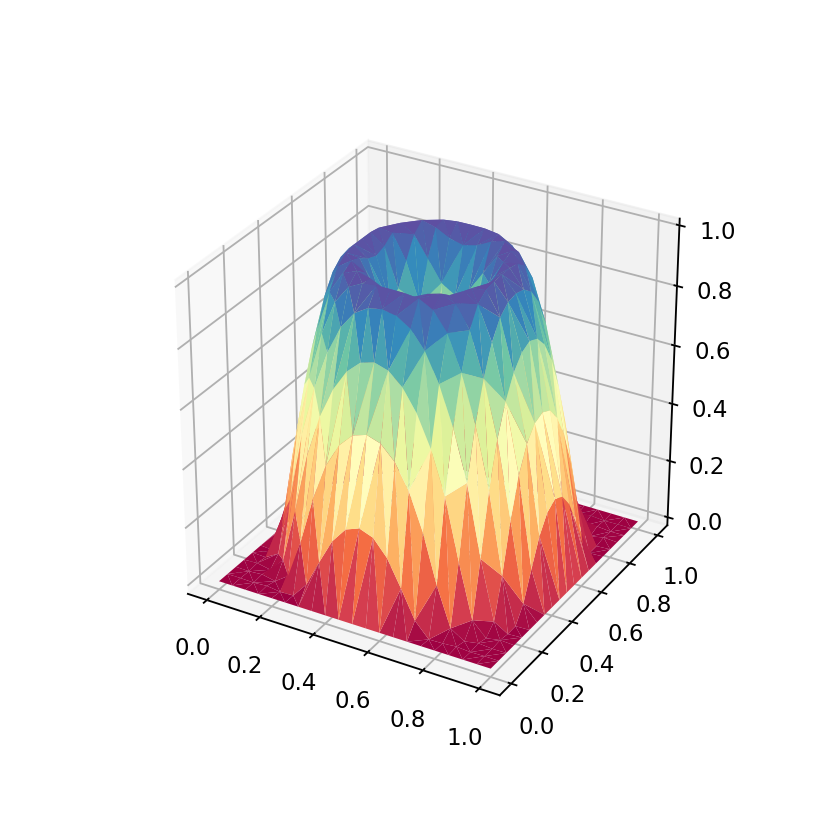

In [23]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

degree = 5 #degree of basis functions
nelems = 10 #number of elements along edge of unit square


#Connectivity :  6──7──8
#                │  │  │
#                3──4──5
#                │  │  │
#                0──1──2


topo, geom =ntl.mesh.multipatch(patches=[[0, 3, 1, 4], [3, 6, 4, 7], [4, 7, 5, 8], [1, 4, 2, 5]],
                                patchverts=[[0,0], [.5, 0], [1, 0], [0, .5], [.5, .5], [1, .5], 
                                            [0, 1], [.5, 1], [1, 1]],
                               nelems= nelems)

topo0 = topo['patch0'] #[0, 3, 1, 4]
topo1 = topo['patch1'] #[3, 6, 4, 7]
topo2 = topo['patch2'] #[4, 7, 5, 8]
topo3 = topo['patch3'] #[1, 4, 2, 5]

ns = ntl.function.Namespace()
ns.x = geom
ns.a = [- geom[1] + 0.5, geom[0] - 0.5]  
ns.kappa = 1e-7
ns.pi = np.pi
ns.basis = topo.basis('spline', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions
sqr = topo2.boundary['bottom'].integral('( u - sin(2 pi (x_0 - 0.5))  )^2 d:x' @ ns, degree= degree*2)

sqr += topo0.boundary['bottom'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo3.boundary['bottom'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo0.boundary['left'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo1.boundary['left'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo1.boundary['top'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo2.boundary['top'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo2.boundary['right'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo3.boundary['right'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
sqr += topo0.boundary['left'].integral(' ( u - 0)^2 d:x' @ns, degree = degree * 2)
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral( 'tau a_k basis_i,k (-kappa u_,jj + a_n u_,n)  d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('RF_SUPG.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (5, 5))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u, cmap= plt.cm.Spectral)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('SUPG solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

fig2 = plt.figure(figsize= (5,5))
ax2 = fig2.add_subplot(111, projection ='3d')
ax2.plot_trisurf( x[:, 0], x[:,1], u, cmap=plt.cm.Spectral)

In [9]:
help(ntl.topology.MultipatchTopology)

Help on class MultipatchTopology in module nutils.topology:

class MultipatchTopology(Topology)
 |  MultipatchTopology(patches)
 |  
 |  multipatch topology
 |  
 |  Method resolution order:
 |      MultipatchTopology
 |      Topology
 |      nutils.types.Singleton
 |      nutils.types.Immutable
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, patches)
 |      constructor
 |  
 |  basis_patch(self)
 |      degree zero patchwise discontinuous basis
 |  
 |  basis_spline(self, degree, patchcontinuous=True, knotvalues=None, knotmultiplicities=None, *, continuity=-1)
 |      spline from vertices
 |      
 |      Create a spline basis with degree ``degree`` per patch.  If
 |      ``patchcontinuous``` is true the basis is $C^0$-continuous at patch
 |      interfaces.
 |  
 |  getitem(self, key)
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  build_boundarydata(connectivity)
 |      build b